In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. SETUP & IMPORTS
!pip install -q category_encoders xgboost lightgbm catboost optuna shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter

import optuna
import joblib
import shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 15.5 MB/s eta 0:00:00


In [3]:
# 2. DATA LOADING & INITIAL EXPLORATION

print("=" * 60)
print("PERSONALITY CLASSIFICATION - ENHANCED PIPELINE")
print("=" * 60)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

# Separate target
y = train['Personality']
X = train.drop(['Personality'], axis=1)
X_test_orig = test.copy()

# Encode target variable
y_map = {k: v for v, k in enumerate(y.unique())}
y_inv_map = {v: k for k, v in y_map.items()}
y_enc = y.map(y_map)

print(f"\nTarget encoding:")
for k, v in y_map.items():
    print(f"  {k} -> {v}")


PERSONALITY CLASSIFICATION - ENHANCED PIPELINE
Train shape: (18524, 9), Test shape: (6175, 8)

Target encoding:
  Extrovert -> 0
  Introvert -> 1


In [4]:

# 3. EXPLORATORY DATA ANALYSIS (EDA)

print("\n" + "=" * 60)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 60)

# 3.1 Basic dataset information
print("\nBASIC DATASET INFORMATION")
print("-" * 50)
print("Training data info:")
print(train.info())
print(f"\nMissing values in training data:")
print(train.isnull().sum())
print(f"\nMissing values in test data:")
print(test.isnull().sum())

# 3.2 Target distribution
print(f"\nTARGET DISTRIBUTION")
print("-" * 30)
print(y.value_counts())
print(f"\nClass balance:")
print(y.value_counts(normalize=True))



EXPLORATORY DATA ANALYSIS

BASIC DATASET INFORMATION
--------------------------------------------------
Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB
None

Missing values in training data:
id                              0
Time_spent_Alone


DATA IMBALANCE ANALYSIS
----------------------------------------


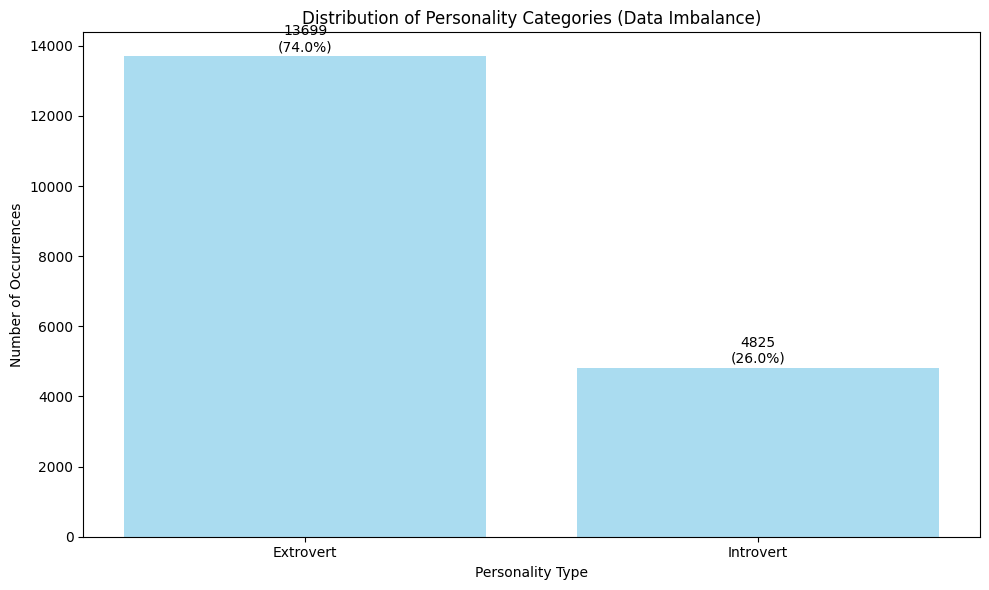

Class Distribution:
  Extrovert: 13699 (74.0%)
  Introvert: 4825 (26.0%)

Imbalance Ratio (max/min): 2.84

DATA BALANCING ANALYSIS
----------------------------------------


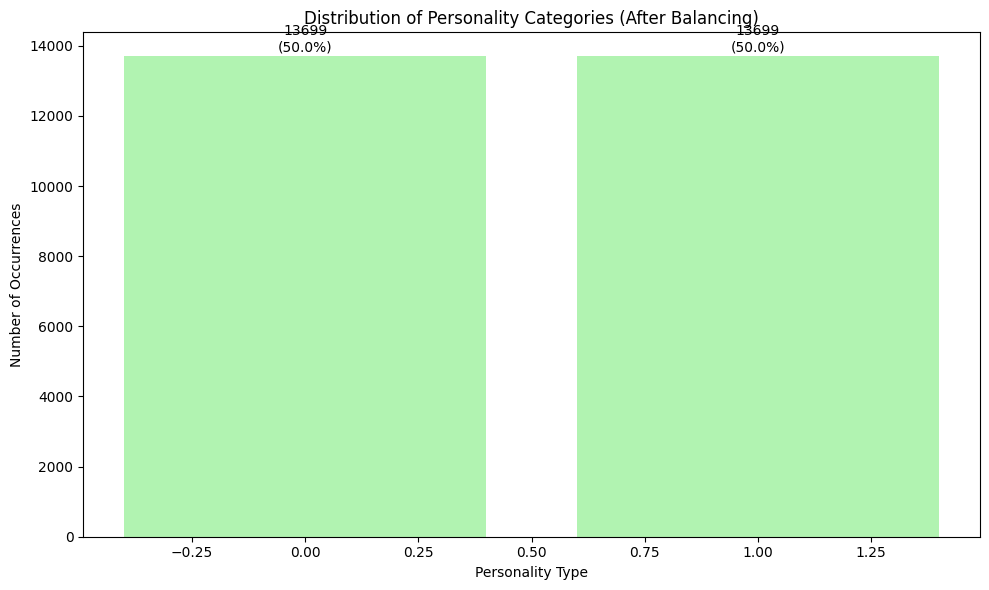

Balanced Class Distribution:
  0: 13699 (50.0%)
  1: 13699 (50.0%)

Balanced Imbalance Ratio (max/min): 1.00

COMPARISON TABLE
--------------------------------------------------
  Personality  Original_Count  Original_Percentage  Balanced_Count  \
0   Extrovert           13699                73.95           13699   
1   Introvert            4825                26.05           13699   

   Balanced_Percentage  
0                 50.0  
1                 50.0  

SUMMARY STATISTICS
------------------------------
Original dataset size: 18524
Balanced dataset size: 27398
Original imbalance ratio: 2.84
Balanced imbalance ratio: 1.00
Balancing technique: RandomOverSampler


In [20]:
# 3.2.1 Data Imbalance Analysis
print(f"\nDATA IMBALANCE ANALYSIS")
print("-" * 40)

# Create imbalance visualization
plt.figure(figsize=(10, 6))
imbalance_counts = y.value_counts()
imbalance_percentages = y.value_counts(normalize=True) * 100

# Create bar plot
bars = plt.bar(imbalance_counts.index, imbalance_counts.values, color='skyblue', alpha=0.7)
plt.title('Distribution of Personality Categories (Data Imbalance)')
plt.xlabel('Personality Type')
plt.ylabel('Number of Occurrences')

# Add value labels on bars
for bar, count, percentage in zip(bars, imbalance_counts.values, imbalance_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('eda_output/data_imbalance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print imbalance statistics
print("Class Distribution:")
for personality, count in imbalance_counts.items():
    percentage = imbalance_percentages[personality]
    print(f"  {personality}: {count} ({percentage:.1f}%)")

# Calculate imbalance ratio
max_count = imbalance_counts.max()
min_count = imbalance_counts.min()
imbalance_ratio = max_count / min_count
print(f"\nImbalance Ratio (max/min): {imbalance_ratio:.2f}")

# Save imbalance summary
with open('eda_output/imbalance_summary.txt', 'w') as f:
    f.write("DATA IMBALANCE SUMMARY\n")
    f.write("=" * 30 + "\n\n")
    f.write("Class Distribution:\n")
    for personality, count in imbalance_counts.items():
        percentage = imbalance_percentages[personality]
        f.write(f"  {personality}: {count} ({percentage:.1f}%)\n")
    f.write(f"\nImbalance Ratio: {imbalance_ratio:.2f}\n")

# 3.2.2 Data Balancing Analysis
print(f"\nDATA BALANCING ANALYSIS")
print("-" * 40)

# Apply balancing technique (RandomOverSampler)
from imblearn.over_sampling import RandomOverSampler

# Reshape y for oversampling
y_reshaped = y_enc.values.reshape(-1, 1)

# Apply RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X.drop('Personality', axis=1), y_reshaped.ravel())

# Get balanced distribution
balanced_counts = pd.Series(y_balanced).value_counts()
balanced_percentages = pd.Series(y_balanced).value_counts(normalize=True) * 100

# Create balanced distribution visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(balanced_counts.index, balanced_counts.values, color='lightgreen', alpha=0.7)
plt.title('Distribution of Personality Categories (After Balancing)')
plt.xlabel('Personality Type')
plt.ylabel('Number of Occurrences')

# Add value labels on bars
for bar, count, percentage in zip(bars, balanced_counts.values, balanced_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('eda_output/data_balanced.png', dpi=300, bbox_inches='tight')
plt.show()

# Print balanced statistics
print("Balanced Class Distribution:")
for personality, count in balanced_counts.items():
    percentage = balanced_percentages[personality]
    print(f"  {personality}: {count} ({percentage:.1f}%)")

# Calculate new imbalance ratio
max_count_balanced = balanced_counts.max()
min_count_balanced = balanced_counts.min()
imbalance_ratio_balanced = max_count_balanced / min_count_balanced
print(f"\nBalanced Imbalance Ratio (max/min): {imbalance_ratio_balanced:.2f}")

# Save balanced summary
with open('eda_output/balanced_summary.txt', 'w') as f:
    f.write("DATA BALANCING SUMMARY\n")
    f.write("=" * 30 + "\n\n")
    f.write("Balanced Class Distribution:\n")
    for personality, count in balanced_counts.items():
        percentage = balanced_percentages[personality]
        f.write(f"  {personality}: {count} ({percentage:.1f}%)\n")
    f.write(f"\nBalanced Imbalance Ratio: {imbalance_ratio_balanced:.2f}\n")

# Create comparison table - FIXED VERSION
print(f"\nCOMPARISON TABLE")
print("-" * 50)

# Create separate DataFrames and then combine
original_df = pd.DataFrame({
    'Personality': imbalance_counts.index,
    'Original_Count': imbalance_counts.values,
    'Original_Percentage': imbalance_percentages.values
})

balanced_df = pd.DataFrame({
    'Personality_Encoded': balanced_counts.index,
    'Balanced_Count': balanced_counts.values,
    'Balanced_Percentage': balanced_percentages.values
})

# Map encoded values back to original personality names
balanced_df['Personality'] = balanced_df['Personality_Encoded'].map(y_inv_map)

# Merge the dataframes
comparison_df = original_df.merge(balanced_df[['Personality', 'Balanced_Count', 'Balanced_Percentage']],
                                 on='Personality', how='outer')

# Sort by original count for better visualization
comparison_df = comparison_df.sort_values('Original_Count', ascending=False)

print(comparison_df.round(2))

# Save comparison table
comparison_df.to_csv('eda_output/imbalance_comparison.csv', index=False)

# Additional summary statistics
print(f"\nSUMMARY STATISTICS")
print("-" * 30)
print(f"Original dataset size: {len(y)}")
print(f"Balanced dataset size: {len(y_balanced)}")
print(f"Original imbalance ratio: {imbalance_ratio:.2f}")
print(f"Balanced imbalance ratio: {imbalance_ratio_balanced:.2f}")
print(f"Balancing technique: RandomOverSampler")


Numeric columns: ['id', 'Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
Categorical columns: ['Stage_fear', 'Drained_after_socializing']


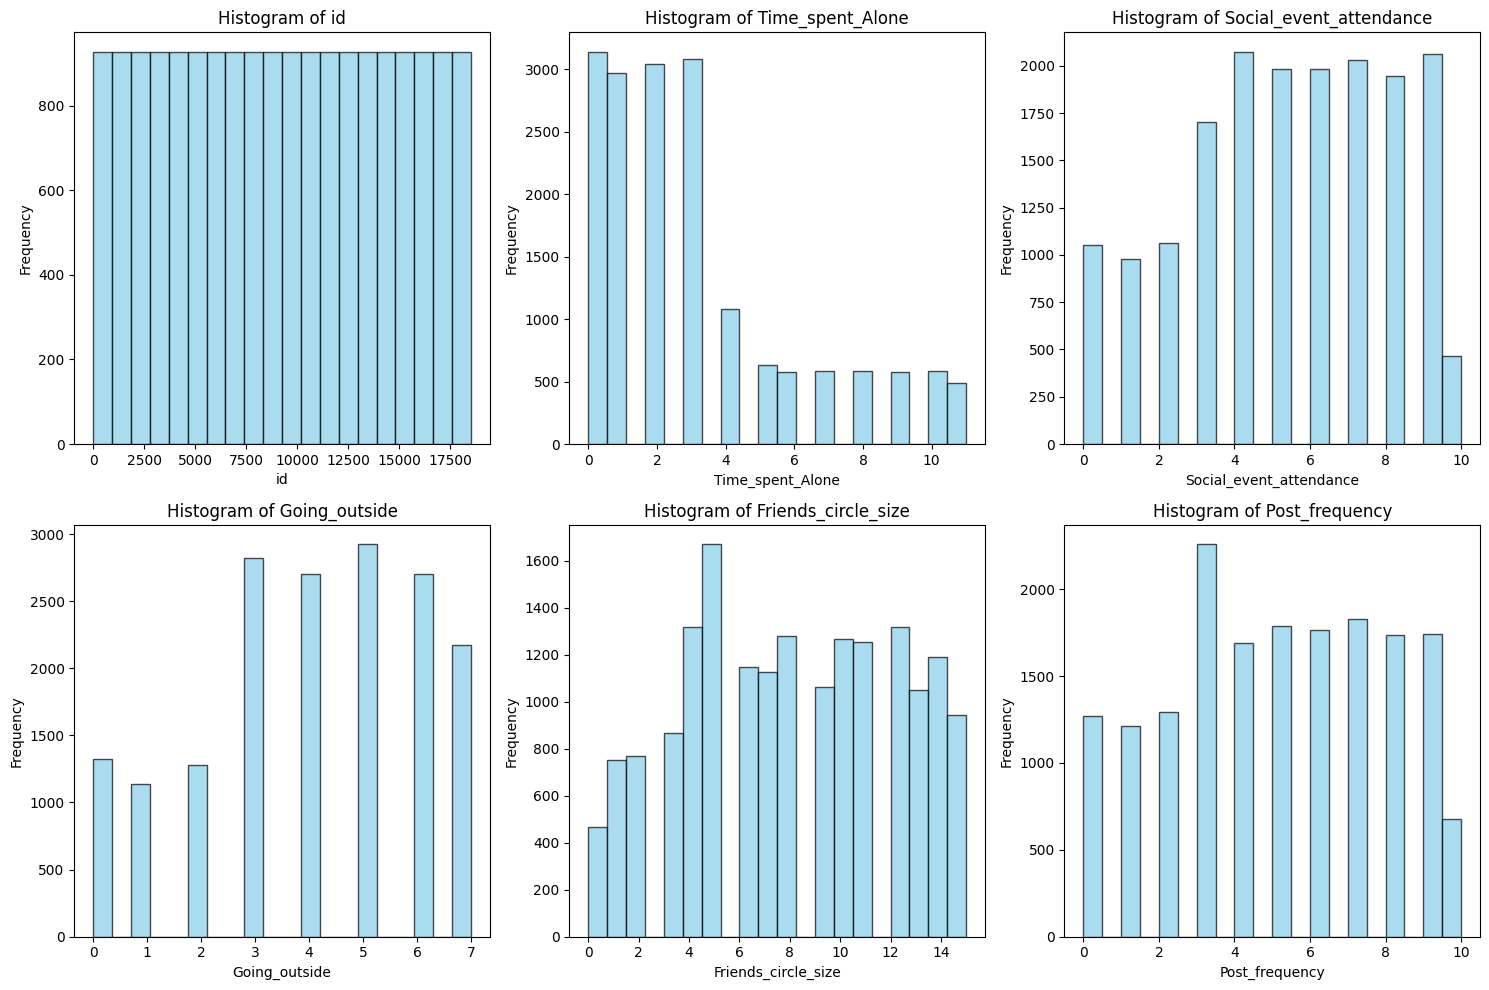

In [6]:
# 3.3 Histograms of numeric features
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")

# Create EDA output directory
import os
if not os.path.exists('eda_output'):
    os.makedirs('eda_output')

# Histograms
n_features = len(num_cols)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(num_cols):
    axes[idx].hist(X[feature], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[idx].set_title(f'Histogram of {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')

# Hide unused subplots
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('eda_output/hist_numeric_features.png', dpi=300, bbox_inches='tight')
plt.show()



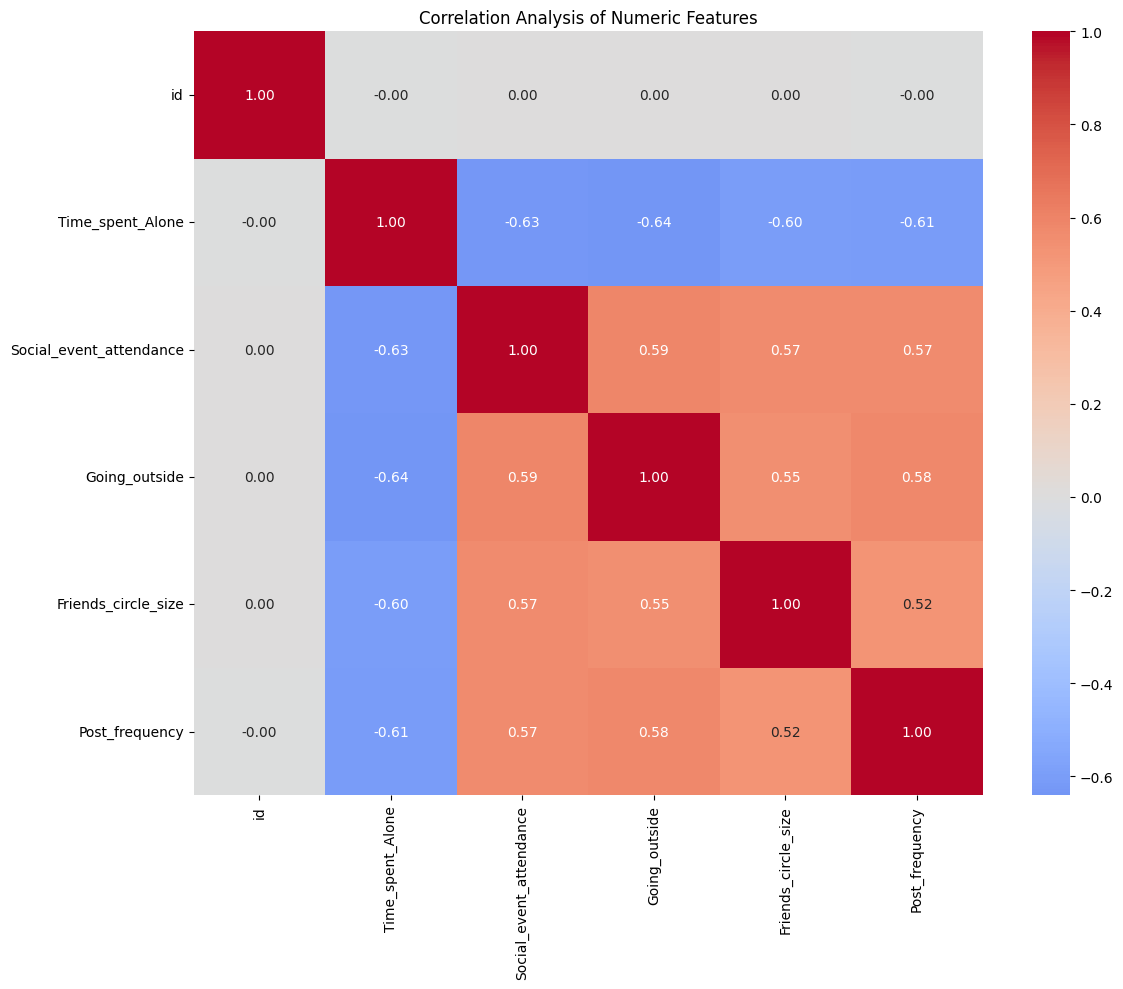

In [7]:
# 3.4 Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = X[num_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Analysis of Numeric Features')
plt.tight_layout()
plt.savefig('eda_output/corr_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


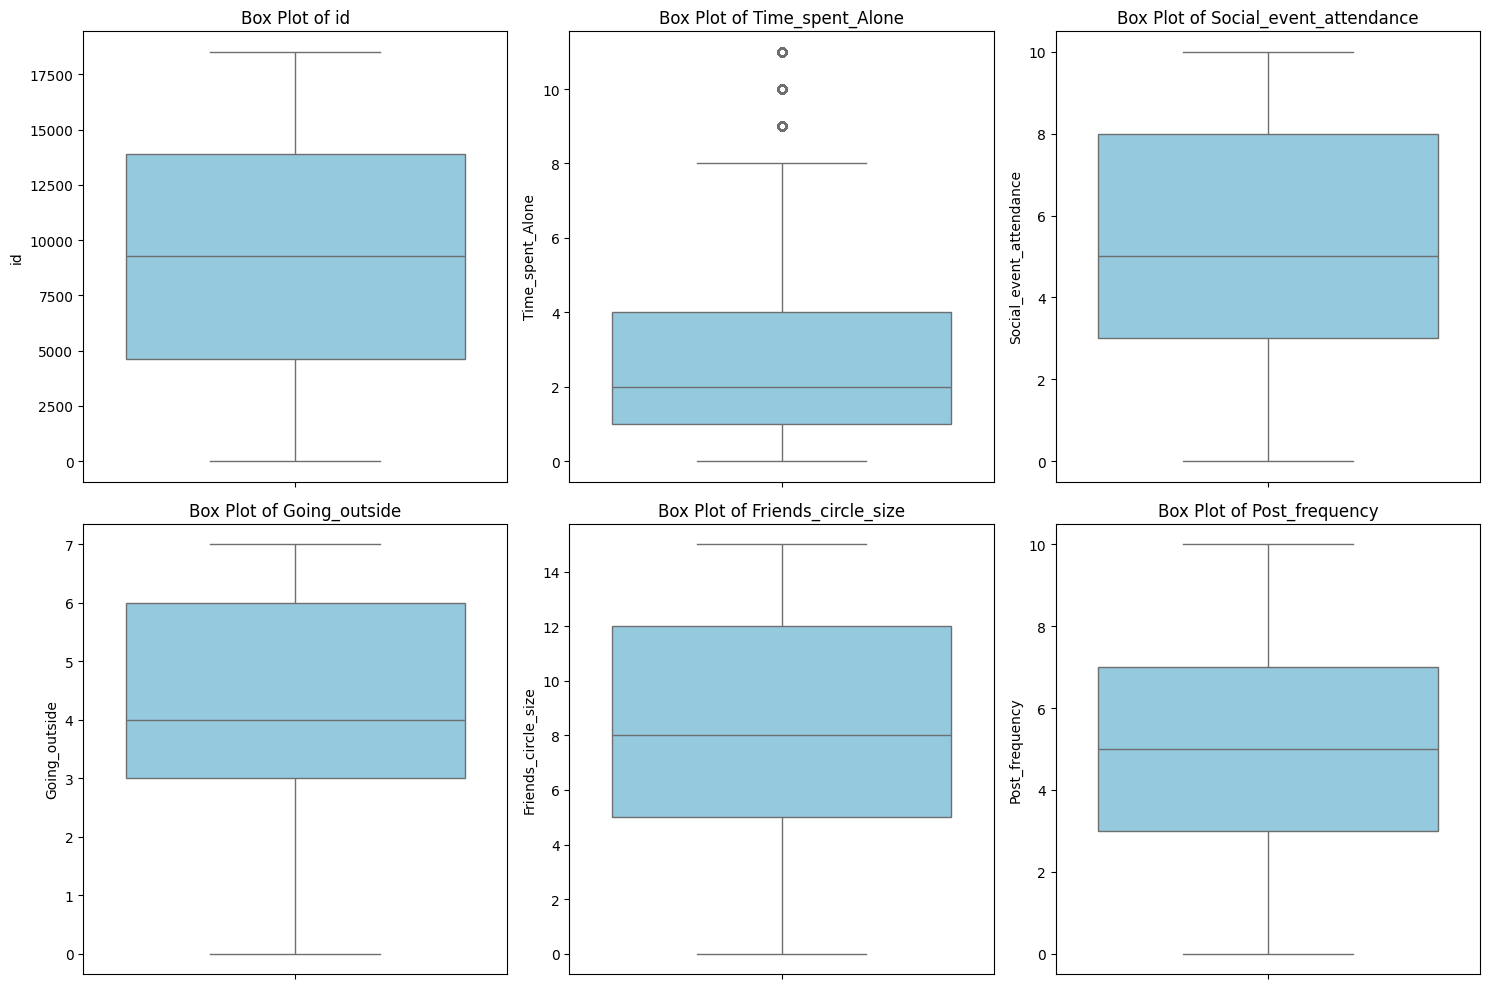

In [8]:
# 3.5 Box plots for outliers
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(num_cols):
    sns.boxplot(y=X[feature], ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'Box Plot of {feature}')
    axes[idx].set_xlabel('')

# Hide unused subplots
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('eda_output/boxplots_outliers.png', dpi=300, bbox_inches='tight')
plt.show()


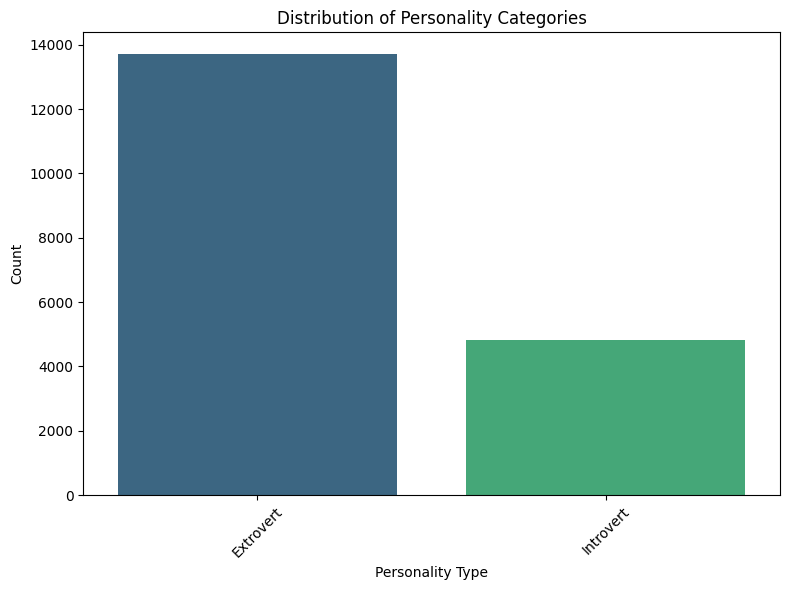

In [9]:
# 3.6 Distribution of personality categories (target)
plt.figure(figsize=(8, 6))
sns.countplot(x=y, palette='viridis')
plt.title('Distribution of Personality Categories')
plt.xlabel('Personality Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('eda_output/personality_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


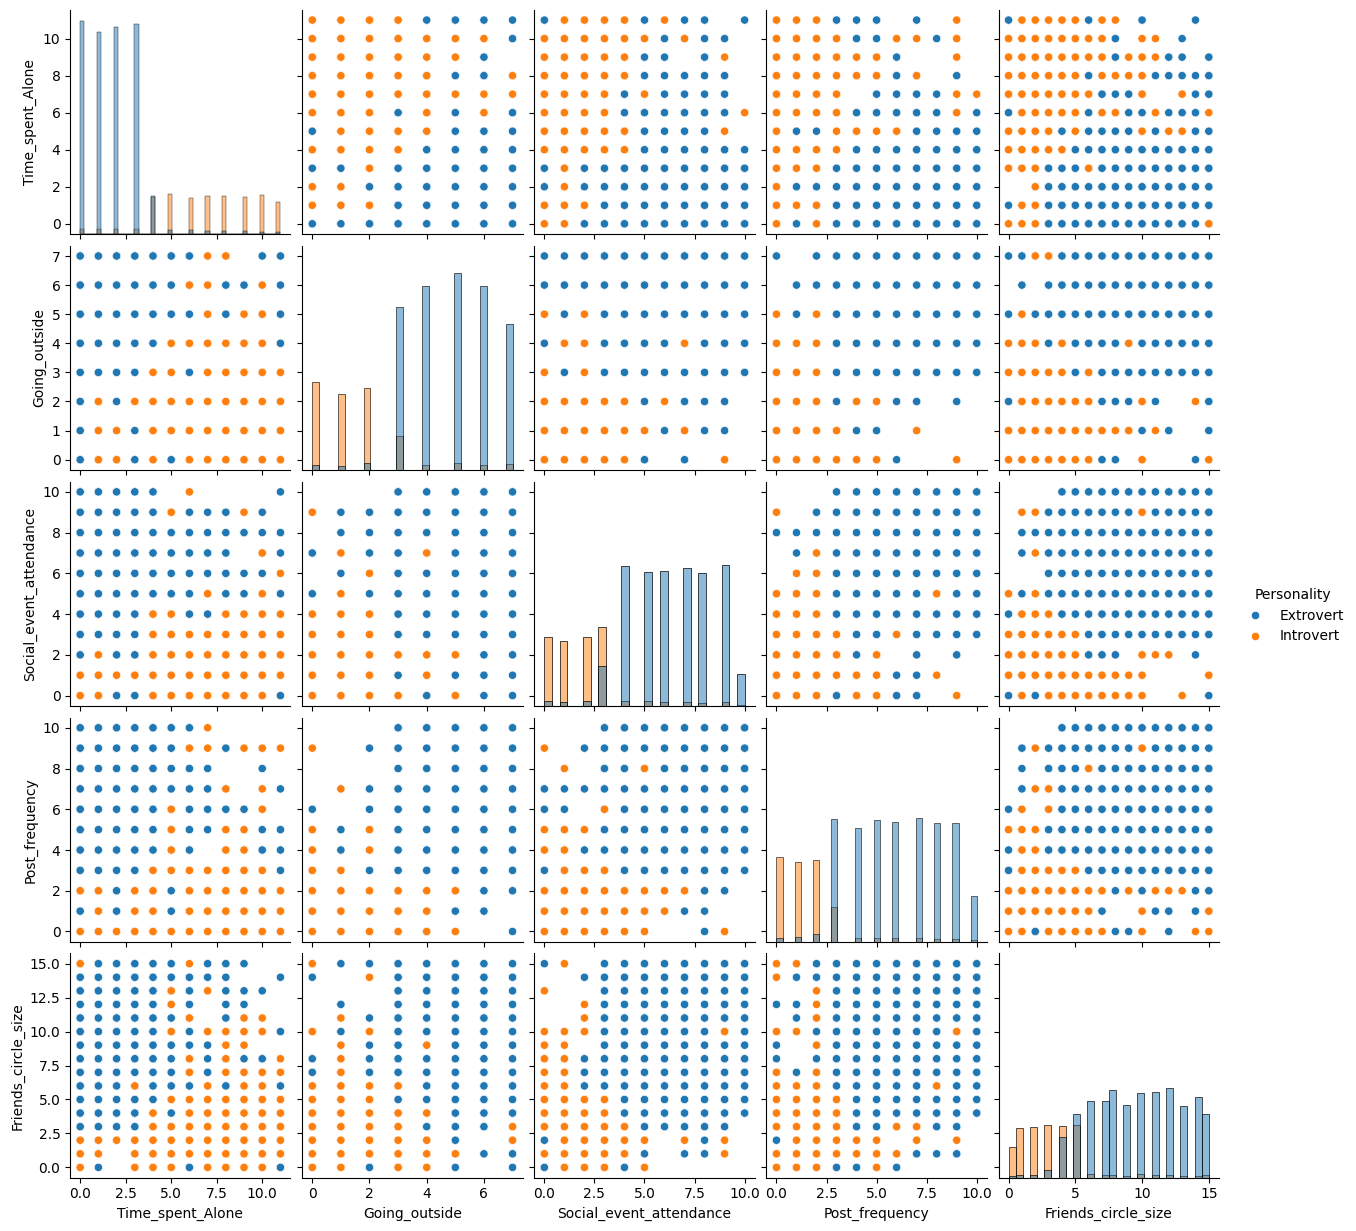


OUTLIER REMOVAL ANALYSIS
Analyzing outliers for feature: id
Original samples: 18524
Outliers removed: 0 (0.00%)
Remaining samples: 18524


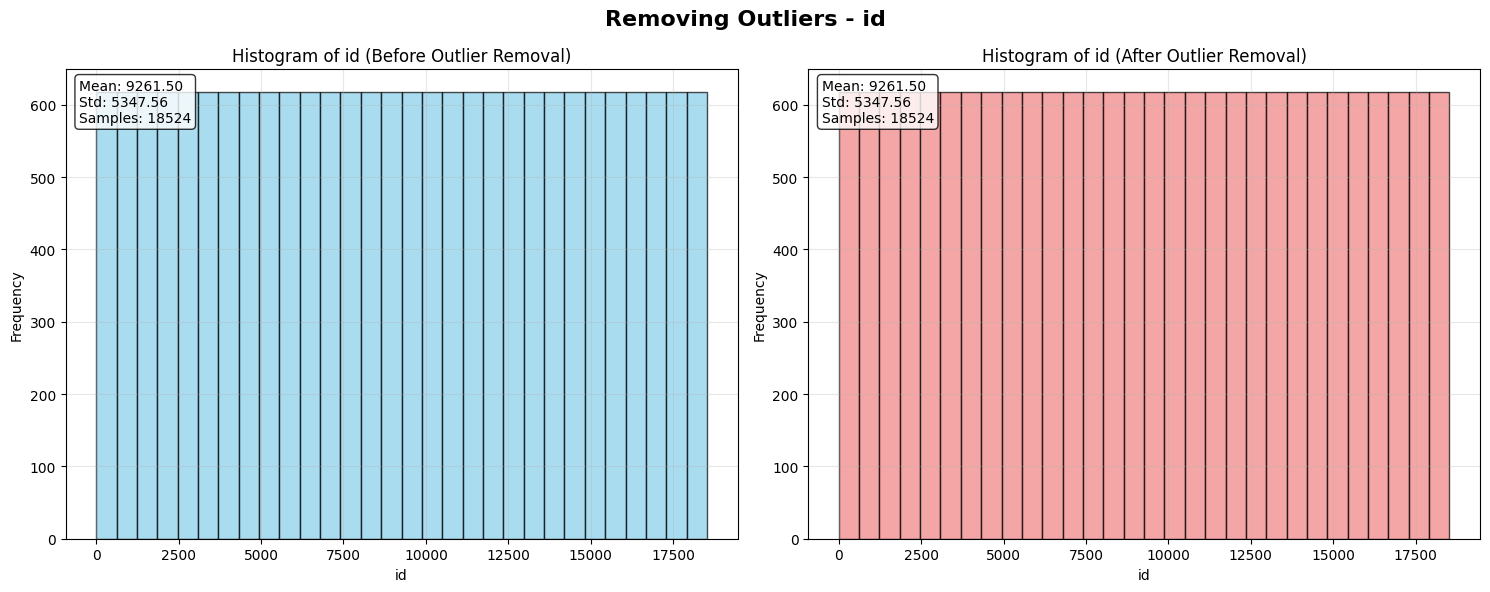

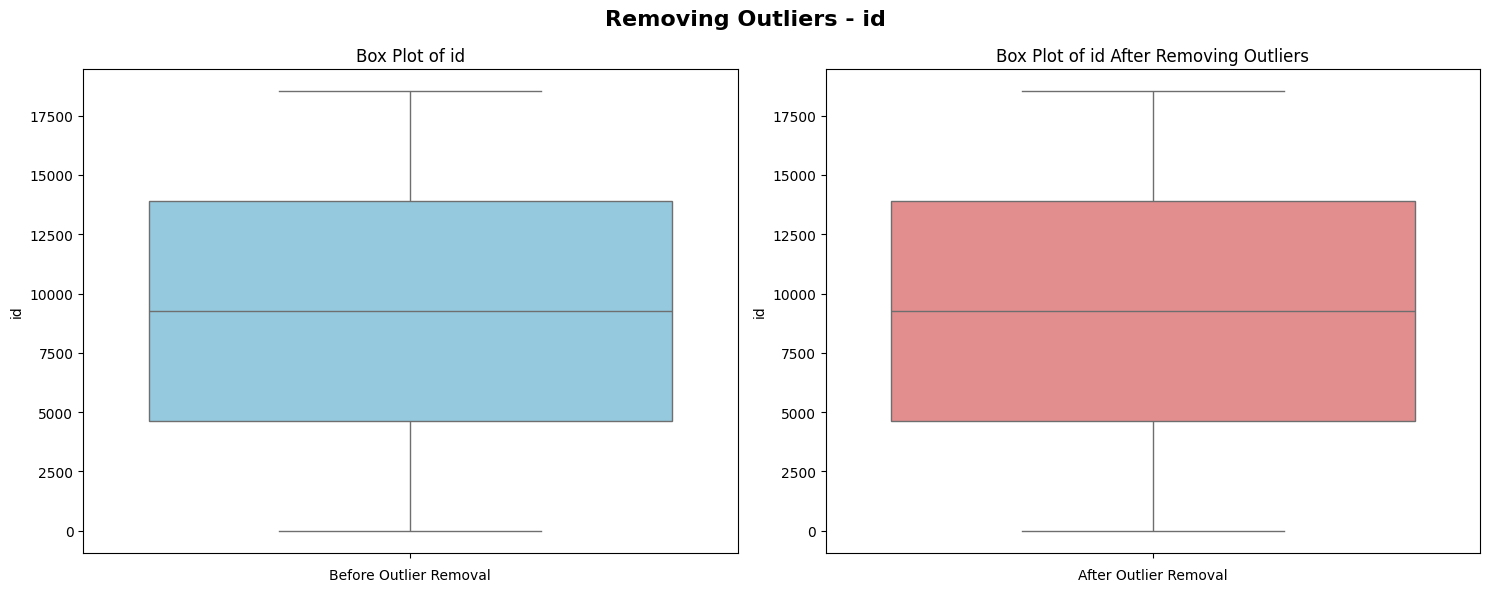


OUTLIER ANALYSIS FOR id
--------------------------------------------------
Original Statistics:
  Mean: 9261.5000
  Std: 5347.5625
  Min: 0.0000
  Max: 18523.0000
  Q1: 4630.7500
  Q3: 13892.2500

After Outlier Removal:
  Mean: 9261.5000
  Std: 5347.5625
  Min: 0.0000
  Max: 18523.0000
  Q1: 4630.7500
  Q3: 13892.2500


In [10]:
# 3.7 Pairplot for key numeric features (top 5 by correlation with target)
if len(num_cols) >= 5:
    # Calculate correlation with target
    target_corr = []
    for col in num_cols:
        corr = abs(X[col].corr(y_enc))
        target_corr.append((col, corr))

    target_corr.sort(key=lambda x: x[1], reverse=True)
    top_features = [col for col, _ in target_corr[:5]]

    # Create pairplot
    pairplot_data = X[top_features].copy()
    pairplot_data['Personality'] = y

    sns.pairplot(pairplot_data, hue='Personality', diag_kind='hist')
    plt.savefig('eda_output/pairplot.png', dpi=300, bbox_inches='tight')
    plt.show()

# Save EDA summary
with open('eda_output/summary.txt', 'w') as f:
    f.write("EXPLORATORY DATA ANALYSIS SUMMARY\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Dataset shapes:\n")
    f.write(f"  Train: {train.shape}\n")
    f.write(f"  Test: {test.shape}\n\n")
    f.write(f"Features:\n")
    f.write(f"  Numeric: {num_cols}\n")
    f.write(f"  Categorical: {cat_cols}\n\n")
    f.write(f"Target distribution:\n")
    f.write(str(y.value_counts()) + "\n\n")
    f.write(f"Missing values:\n")
    f.write(str(train.isnull().sum()) + "\n")


    # 3.8 Outlier Removal Analysis
print("\n" + "=" * 60)
print("OUTLIER REMOVAL ANALYSIS")
print("=" * 60)

# Function to detect and remove outliers using IQR method
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Create mask for outliers
    outlier_mask = (data[column] >= lower_bound) & (data[column] <= upper_bound)
    return data[outlier_mask], outlier_mask

# Select a feature for outlier analysis (you can change this to any numeric feature)
feature_for_analysis = num_cols[0]  # Using first numeric feature
print(f"Analyzing outliers for feature: {feature_for_analysis}")

# Get original data and outlier-removed data
X_original = X.copy()
X_filtered, outlier_mask = remove_outliers_iqr(X_original, feature_for_analysis)

# Calculate outlier statistics
total_samples = len(X_original)
outliers_removed = total_samples - len(X_filtered)
outlier_percentage = (outliers_removed / total_samples) * 100

print(f"Original samples: {total_samples}")
print(f"Outliers removed: {outliers_removed} ({outlier_percentage:.2f}%)")
print(f"Remaining samples: {len(X_filtered)}")

# Create before and after histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before outlier removal
ax1.hist(X_original[feature_for_analysis], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title(f'Histogram of {feature_for_analysis} (Before Outlier Removal)')
ax1.set_xlabel(feature_for_analysis)
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Add statistics text
ax1.text(0.02, 0.98, f'Mean: {X_original[feature_for_analysis].mean():.2f}\nStd: {X_original[feature_for_analysis].std():.2f}\nSamples: {total_samples}',
         transform=ax1.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# After outlier removal
ax2.hist(X_filtered[feature_for_analysis], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_title(f'Histogram of {feature_for_analysis} (After Outlier Removal)')
ax2.set_xlabel(feature_for_analysis)
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

# Add statistics text
ax2.text(0.02, 0.98, f'Mean: {X_filtered[feature_for_analysis].mean():.2f}\nStd: {X_filtered[feature_for_analysis].std():.2f}\nSamples: {len(X_filtered)}',
         transform=ax2.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle(f'Removing Outliers - {feature_for_analysis}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('eda_output/outlier_removal_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

# Create box plots for comparison (similar to your example image)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before outlier removal
sns.boxplot(y=X_original[feature_for_analysis], ax=ax1, color='skyblue')
ax1.set_title(f'Box Plot of {feature_for_analysis}')
ax1.set_xlabel('Before Outlier Removal')

# After outlier removal
sns.boxplot(y=X_filtered[feature_for_analysis], ax=ax2, color='lightcoral')
ax2.set_title(f'Box Plot of {feature_for_analysis} After Removing Outliers')
ax2.set_xlabel('After Outlier Removal')

plt.suptitle(f'Removing Outliers - {feature_for_analysis}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('eda_output/outlier_removal_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed outlier statistics
print(f"\nOUTLIER ANALYSIS FOR {feature_for_analysis}")
print("-" * 50)
print(f"Original Statistics:")
print(f"  Mean: {X_original[feature_for_analysis].mean():.4f}")
print(f"  Std: {X_original[feature_for_analysis].std():.4f}")
print(f"  Min: {X_original[feature_for_analysis].min():.4f}")
print(f"  Max: {X_original[feature_for_analysis].max():.4f}")
print(f"  Q1: {X_original[feature_for_analysis].quantile(0.25):.4f}")
print(f"  Q3: {X_original[feature_for_analysis].quantile(0.75):.4f}")

print(f"\nAfter Outlier Removal:")
print(f"  Mean: {X_filtered[feature_for_analysis].mean():.4f}")
print(f"  Std: {X_filtered[feature_for_analysis].std():.4f}")
print(f"  Min: {X_filtered[feature_for_analysis].min():.4f}")
print(f"  Max: {X_filtered[feature_for_analysis].max():.4f}")
print(f"  Q1: {X_filtered[feature_for_analysis].quantile(0.25):.4f}")
print(f"  Q3: {X_filtered[feature_for_analysis].quantile(0.75):.4f}")

# Save outlier analysis summary
with open('eda_output/outlier_analysis.txt', 'w') as f:
    f.write("OUTLIER REMOVAL ANALYSIS\n")
    f.write("=" * 30 + "\n\n")
    f.write(f"Feature analyzed: {feature_for_analysis}\n\n")
    f.write("Original Statistics:\n")
    f.write(f"  Mean: {X_original[feature_for_analysis].mean():.4f}\n")
    f.write(f"  Std: {X_original[feature_for_analysis].std():.4f}\n")
    f.write(f"  Min: {X_original[feature_for_analysis].min():.4f}\n")
    f.write(f"  Max: {X_original[feature_for_analysis].max():.4f}\n\n")
    f.write("After Outlier Removal:\n")
    f.write(f"  Mean: {X_filtered[feature_for_analysis].mean():.4f}\n")
    f.write(f"  Std: {X_filtered[feature_for_analysis].std():.4f}\n")
    f.write(f"  Min: {X_filtered[feature_for_analysis].min():.4f}\n")
    f.write(f"  Max: {X_filtered[feature_for_analysis].max():.4f}\n\n")
    f.write(f"Outliers removed: {outliers_removed} ({outlier_percentage:.2f}%)\n")
    f.write(f"Remaining samples: {len(X_filtered)}\n")

In [11]:
# 4. PREPROCESSING

print("\n" + "=" * 60)
print("PREPROCESSING")
print("=" * 60)

# 4.1 Identify columns and drop 'id'
drop_cols = ['id']
if 'id' in X.columns:
    X = X.drop('id', axis=1)
if 'id' in X_test_orig.columns:
    X_test_orig = X_test_orig.drop('id', axis=1)

# 4.2 Re-identify columns after dropping 'id'
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")

# 4.3 Handle missing values
print("Handling missing values...")
print(f"Missing values in training data: {X.isnull().sum().sum()}")
print(f"Missing values in test data: {X_test_orig.isnull().sum().sum()}")

# 4.4 Numeric imputation (only on original numeric columns, not encoded ones)
original_num_cols = [col for col in num_cols if not any(suffix in col for suffix in ['_No', '_Yes'])]
print(f"Original numeric columns for imputation: {original_num_cols}")

num_imputer = SimpleImputer(strategy='median')
X[original_num_cols] = num_imputer.fit_transform(X[original_num_cols])
X_test = X_test_orig.copy()
X_test[original_num_cols] = num_imputer.transform(X_test[original_num_cols])

# 4.5 Categorical imputation (only if categorical columns exist, excluding target)
if len(cat_cols) > 0:
    # Remove 'Personality' from categorical columns for test data processing
    cat_cols_for_processing = [col for col in cat_cols if col != 'Personality']

    if len(cat_cols_for_processing) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        X[cat_cols_for_processing] = cat_imputer.fit_transform(X[cat_cols_for_processing])
        X_test[cat_cols_for_processing] = cat_imputer.transform(X_test[cat_cols_for_processing])

# 4.6 Encoding (only if categorical columns exist, excluding target)
encoders = {}
if len(cat_cols) > 0:
    # Remove 'Personality' from categorical columns for encoding
    cat_cols_for_encoding = [col for col in cat_cols if col != 'Personality']

    if len(cat_cols_for_encoding) > 0:
        print("Encoding categorical variables...")
        for col in cat_cols_for_encoding:
            if X[col].nunique() <= 5:
                # One-hot encoding for low cardinality
                ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                ohe.fit(X[[col]])
                ohe_cols = [f"{col}_{cat}" for cat in ohe.categories_[0]]
                ohe_train = pd.DataFrame(ohe.transform(X[[col]]), columns=ohe_cols, index=X.index)
                ohe_test = pd.DataFrame(ohe.transform(X_test[[col]]), columns=ohe_cols, index=X_test.index)

                X = pd.concat([X.drop(col, axis=1), ohe_train], axis=1)
                X_test = pd.concat([X_test.drop(col, axis=1), ohe_test], axis=1)
                encoders[col] = ohe
                print(f"  {col}: One-hot encoded -> {len(ohe_cols)} features")
            else:
                # Target encoding for high cardinality
                te = TargetEncoder()
                te.fit(X[col], y)
                X[col] = te.transform(X[col])
                X_test[col] = te.transform(X_test[col])
                encoders[col] = te
                print(f"  {col}: Target encoded")

# 4.7 Re-identify numeric columns after encoding (in case some were added)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# 4.8 Scaling (use the same columns that exist in both train and test)
print("Scaling numeric features...")

# Ensure test data has the same columns as training data
test_num_cols = X_test.select_dtypes(include=[np.number]).columns.tolist()
common_num_cols = list(set(num_cols) & set(test_num_cols))
print(f"Common numeric columns for scaling: {common_num_cols}")

# Fit scaler only on common columns
scaler = StandardScaler()
X[common_num_cols] = scaler.fit_transform(X[common_num_cols])
X_test[common_num_cols] = scaler.transform(X_test[common_num_cols])

# 4.9 Save preprocessed data
X['Personality'] = y
X.to_csv('train_preprocessed.csv', index=False)
X_test.to_csv('test_preprocessed.csv', index=False)

# Save preprocessing objects
joblib.dump(num_imputer, 'num_imputer.pkl')
if len(cat_cols) > 0:
    joblib.dump(cat_imputer, 'cat_imputer.pkl')
joblib.dump(encoders, 'encoders.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(y_inv_map, 'y_inv_map.pkl')

print("Preprocessing completed and saved!")


PREPROCESSING
Numeric columns: ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
Categorical columns: ['Stage_fear', 'Drained_after_socializing']
Handling missing values...
Missing values in training data: 9196
Missing values in test data: 3076
Original numeric columns for imputation: ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
Encoding categorical variables...
  Stage_fear: One-hot encoded -> 2 features
  Drained_after_socializing: One-hot encoded -> 2 features
Scaling numeric features...
Common numeric columns for scaling: ['Social_event_attendance', 'Friends_circle_size', 'Going_outside', 'Stage_fear_No', 'Drained_after_socializing_No', 'Post_frequency', 'Drained_after_socializing_Yes', 'Time_spent_Alone', 'Stage_fear_Yes']
Preprocessing completed and saved!



MODEL TRAINING & EVALUATION

Training LogisticRegression...
LogisticRegression | CV Accuracy: 0.9680 ± 0.0033
   Train Accuracy: 0.9680 | Test Accuracy: 0.9714

Training DecisionTree...
DecisionTree    | CV Accuracy: 0.9673 ± 0.0039
   Train Accuracy: 0.9690 | Test Accuracy: 0.9703

Training RandomForest...
RandomForest    | CV Accuracy: 0.9681 ± 0.0031
   Train Accuracy: 0.9686 | Test Accuracy: 0.9709

Training KNN...
KNN             | CV Accuracy: 0.9677 ± 0.0032
   Train Accuracy: 0.9681 | Test Accuracy: 0.9709

Training XGBoost...
XGBoost         | CV Accuracy: 0.9681 ± 0.0029
   Train Accuracy: 0.9686 | Test Accuracy: 0.9711

Training LightGBM...
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

,cv_accuracy,train_accuracy,test_accuracy,f1_score
LogisticRegression,0.968014,0.968014,0.97139,0.971419
LightGBM,0.967947,0.968824,0.97139,0.971428
CatBoost,0.968419,0.968824,0.97139,0.971428
XGBoost,0.968149,0.968554,0.97112,0.971163
RandomForest,0.968149,0.968621,0.97085,0.970889
KNN,0.967677,0.968149,0.97085,0.970889
DecisionTree,0.967272,0.969026,0.97031,0.970350


FileNotFoundError: [Errno 2] No such file or directory: 'docs/images/model_accuracy_comparison.png'

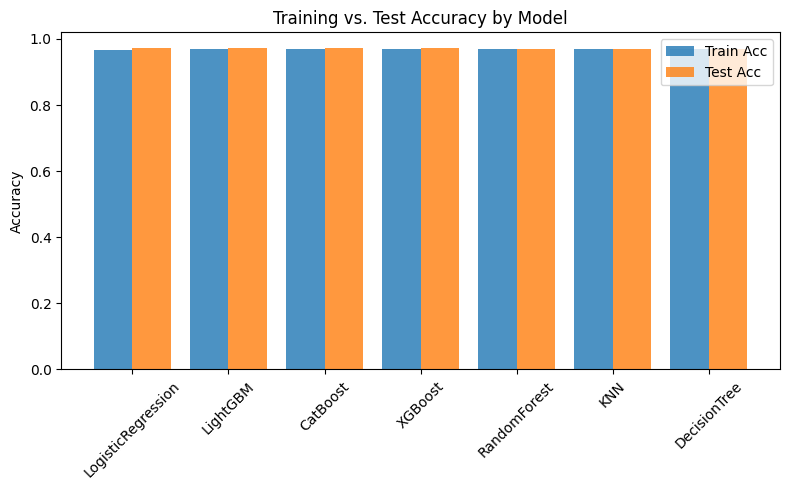

In [12]:
# 5. MODEL TRAINING & EVALUATION

print("\n" + "=" * 60)
print("MODEL TRAINING & EVALUATION")
print("=" * 60)

# 5.1 Split data for evaluation
X_train, X_val, y_train, y_val = train_test_split(X.drop('Personality', axis=1), y_enc,
                                                   test_size=0.2, random_state=42, stratify=y_enc)

# 5.2 Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_jobs=-1, random_state=42),
    'KNN': KNeighborsClassifier(n_jobs=-1),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',
                             n_jobs=-1, random_state=42),
    'LightGBM': LGBMClassifier(n_jobs=-1, random_state=42, verbose=0),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

# 5.3 Hyperparameter grids
param_grids = {
    'LogisticRegression': {'C': [0.1, 1, 10], 'class_weight': [None, 'balanced']},
    'DecisionTree': {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]},
    'RandomForest': {'n_estimators': [50, 100], 'max_depth': [5, 10], 'min_samples_split': [2, 5]},
    'KNN': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    'XGBoost': {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.3]},
    'LightGBM': {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.3]},
    'CatBoost': {'iterations': [50, 100], 'depth': [3, 5], 'learning_rate': [0.1, 0.3]}
}

# 5.4 Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5.5 Train and evaluate models
raw_results = {}
best_estimators = {}
train_accuracies = {}
test_accuracies = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # GridSearch for hyperparameter tuning
    gs = GridSearchCV(model, param_grids[name], cv=skf, scoring='accuracy', n_jobs=-1)
    gs.fit(X_train, y_train)
    best = gs.best_estimator_

    # Cross-validation scores
    cv_scores = cross_val_score(best, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)

    # Train and test predictions
    y_train_pred = best.predict(X_train)
    y_val_pred = best.predict(X_val)

    # Calculate metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_val, y_val_pred)

    # Store results
    raw_results[name] = {
        'best_params': gs.best_params_,
        'cv_accuracy': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'f1_score': f1_score(y_val, y_val_pred, average='weighted'),
        'precision': f1_score(y_val, y_val_pred, average='weighted'),  # Using f1_score as placeholder
        'recall': f1_score(y_val, y_val_pred, average='weighted')      # Using f1_score as placeholder
    }

    best_estimators[name] = best
    train_accuracies[name] = train_acc
    test_accuracies[name] = test_acc

    print(f"{name:15s} | CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"   Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

# 5.6 Create results DataFrame
results_df = pd.DataFrame(raw_results).T
results_df = results_df.sort_values('test_accuracy', ascending=False)

print(f"\nFINAL MODEL RANKINGS")
print("=" * 60)
print(results_df[['cv_accuracy', 'train_accuracy', 'test_accuracy', 'f1_score']].round(4))

# Save results
results_df.to_csv('model_comparison.csv')

# 6. VISUALIZATION - ACCURACY COMPARISON

print("\n" + "=" * 60)
print("VISUALIZATION")
print("=" * 60)


# MODEL EVALUATION SUMMARY

import pandas as pd

results_df = pd.read_csv('model_comparison.csv', index_col=0)

# 1) Display final ranking
print("Final Model Rankings (by test accuracy):")
display(results_df[['cv_accuracy','train_accuracy','test_accuracy','f1_score']])

# 2) Plot train vs. test accuracy
import matplotlib.pyplot as plt
models = results_df.index.tolist()
train_acc = results_df['train_accuracy']
test_acc  = results_df['test_accuracy']

x = range(len(models))
plt.figure(figsize=(8,5))
plt.bar([i-0.2 for i in x], train_acc, width=0.4, label='Train Acc', alpha=0.8)
plt.bar([i+0.2 for i in x], test_acc, width=0.4, label='Test Acc', alpha=0.8)
plt.xticks(x, models, rotation=45)
plt.ylabel('Accuracy')
plt.title('Training vs. Test Accuracy by Model')
plt.legend()
plt.tight_layout()
plt.savefig('docs/images/model_accuracy_comparison.png', dpi=200)
plt.show()


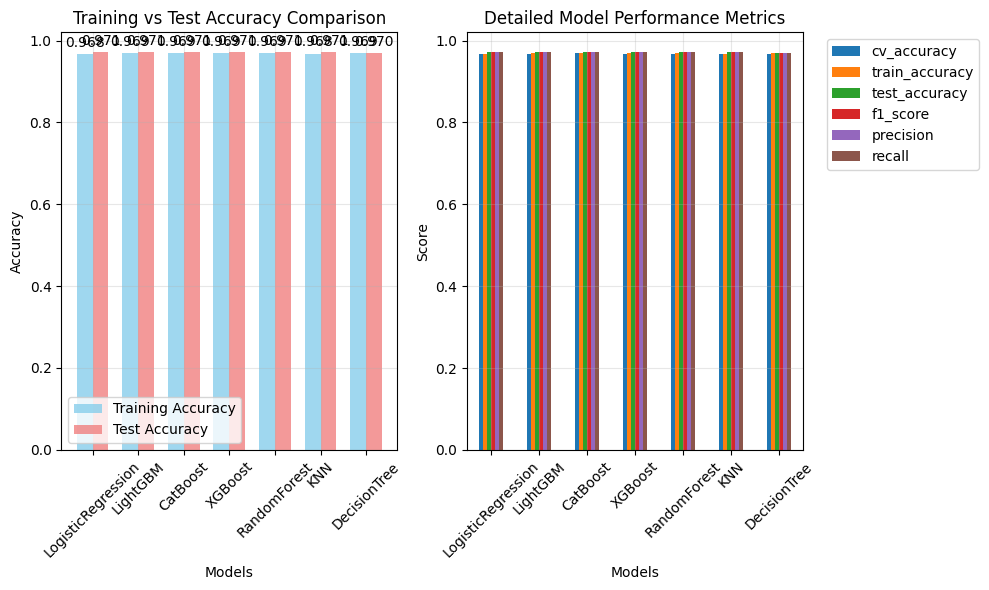

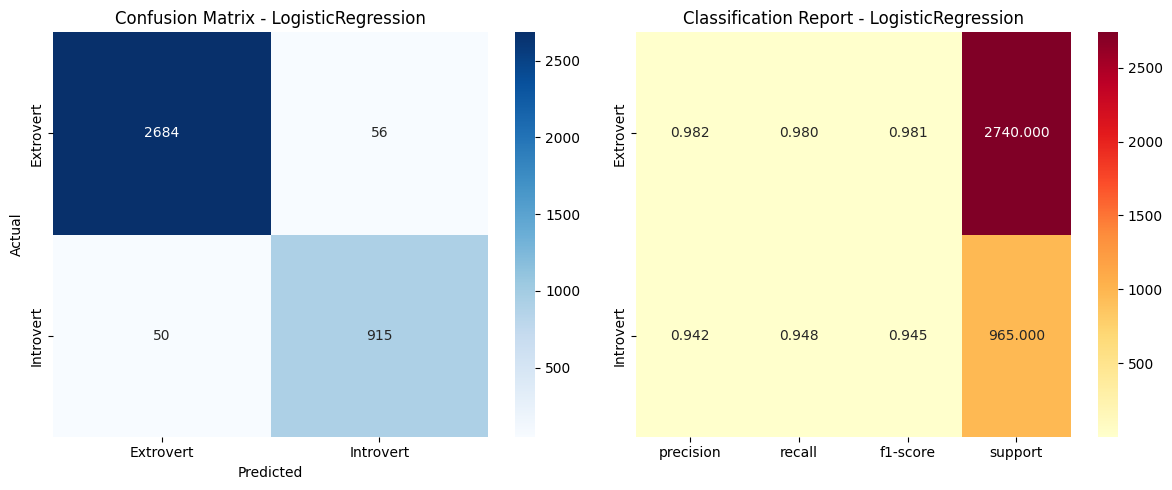

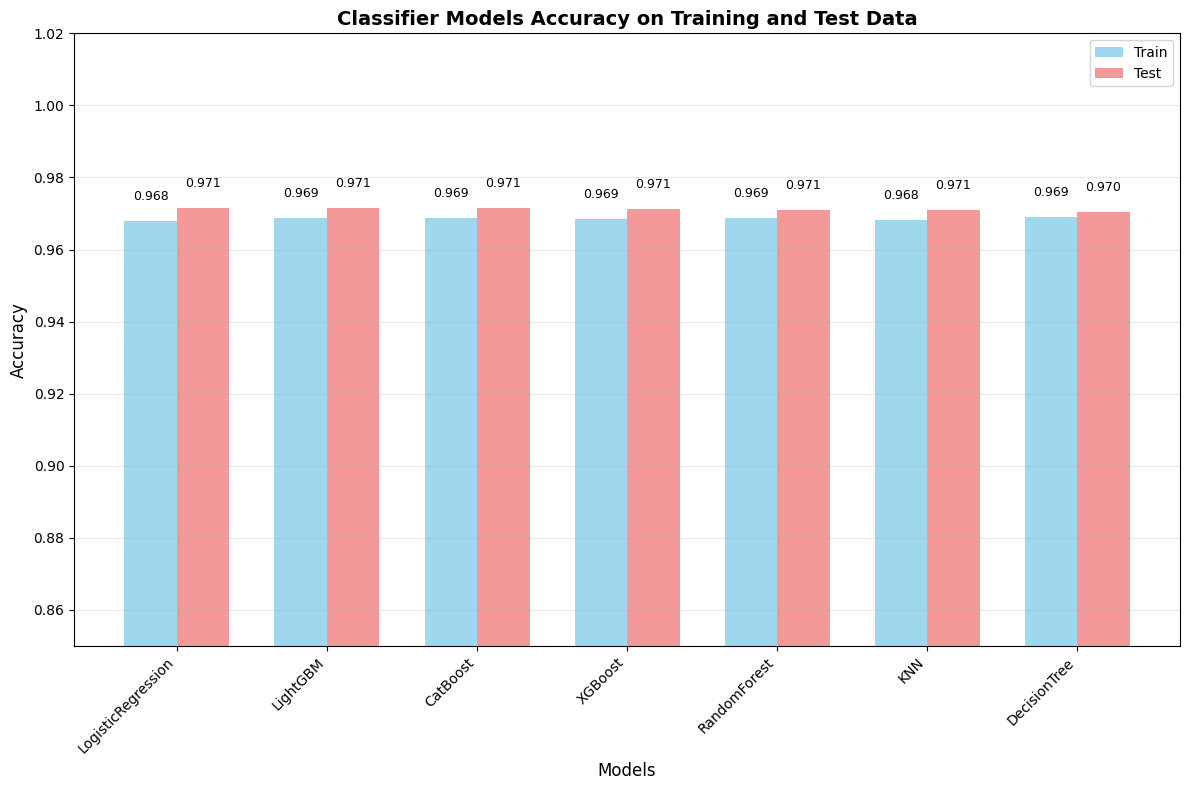


MODEL ACCURACY SUMMARY:
--------------------------------------------------
LogisticRegression: Train=0.9680, Test=0.9714, Gap=-0.0034
LightGBM       : Train=0.9688, Test=0.9714, Gap=-0.0026
CatBoost       : Train=0.9688, Test=0.9714, Gap=-0.0026
XGBoost        : Train=0.9686, Test=0.9711, Gap=-0.0026
RandomForest   : Train=0.9686, Test=0.9709, Gap=-0.0022
KNN            : Train=0.9681, Test=0.9709, Gap=-0.0027
DecisionTree   : Train=0.9690, Test=0.9703, Gap=-0.0013


In [24]:
# 6.1 Create accuracy comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training vs Test Accuracy - CORRECTED VERSION
models_list = list(results_df.index)  # Use actual model names from results
train_acc_list = results_df['train_accuracy'].values  # Use actual training accuracies
test_acc_list = results_df['test_accuracy'].values    # Use actual test accuracies

x = np.arange(len(models_list))
width = 0.35

ax1.bar(x - width/2, train_acc_list, width, label='Training Accuracy', alpha=0.8, color='skyblue')
ax1.bar(x + width/2, test_acc_list, width, label='Test Accuracy', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training vs Test Accuracy Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(models_list, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, (train_acc, test_acc) in enumerate(zip(train_acc_list, test_acc_list)):
    ax1.text(i - width/2, train_acc + 0.01, f'{train_acc:.3f}', ha='center', va='bottom')
    ax1.text(i + width/2, test_acc + 0.01, f'{test_acc:.3f}', ha='center', va='bottom')

# 6.2 Detailed metrics comparison
metrics_df = results_df[['cv_accuracy', 'train_accuracy', 'test_accuracy', 'f1_score', 'precision', 'recall']]
metrics_df.plot(kind='bar', ax=ax2, figsize=(10, 6))
ax2.set_title('Detailed Model Performance Metrics')
ax2.set_xlabel('Models')
ax2.set_ylabel('Score')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 6.3 Confusion Matrix for Best Model
best_model_name = results_df['test_accuracy'].idxmax()
best_model = best_estimators[best_model_name]

y_val_pred_best = best_model.predict(X_val)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(y_map.keys()),
            yticklabels=list(y_map.keys()), ax=ax1)
ax1.set_title(f'Confusion Matrix - {best_model_name}')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Classification Report
report = classification_report(y_val, y_val_pred_best,
                             target_names=list(y_map.keys()),
                             output_dict=True)
report_df = pd.DataFrame(report).transpose()

sns.heatmap(report_df.iloc[:-3, :].astype(float), annot=True, fmt='.3f',
            cmap='YlOrRd', ax=ax2)
ax2.set_title(f'Classification Report - {best_model_name}')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 6.4 Create Training vs Test Accuracy Histogram
plt.figure(figsize=(12, 8))

# Create bar positions
x = np.arange(len(models_list))
width = 0.35

# Create bars
bars1 = plt.bar(x - width/2, train_acc_list, width, label='Train', color='skyblue', alpha=0.8)
bars2 = plt.bar(x + width/2, test_acc_list, width, label='Test', color='lightcoral', alpha=0.8)

# Customize the plot
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Classifier Models Accuracy on Training and Test Data', fontsize=14, fontweight='bold')
plt.xticks(x, models_list, rotation=45, ha='right')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars1, train_acc_list):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

for bar, acc in zip(bars2, test_acc_list):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

# Set y-axis limits
plt.ylim(0.85, 1.02)
plt.tight_layout()
plt.savefig('training_vs_test_accuracy_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\nMODEL ACCURACY SUMMARY:")
print("-" * 50)
for i, model in enumerate(models_list):
    train_acc = train_acc_list[i]
    test_acc = test_acc_list[i]
    gap = train_acc - test_acc
    print(f"{model:15s}: Train={train_acc:.4f}, Test={test_acc:.4f}, Gap={gap:.4f}")


FEATURE IMPORTANCE ANALYSIS
Feature importance not available for LogisticRegression
Attempting SHAP analysis...


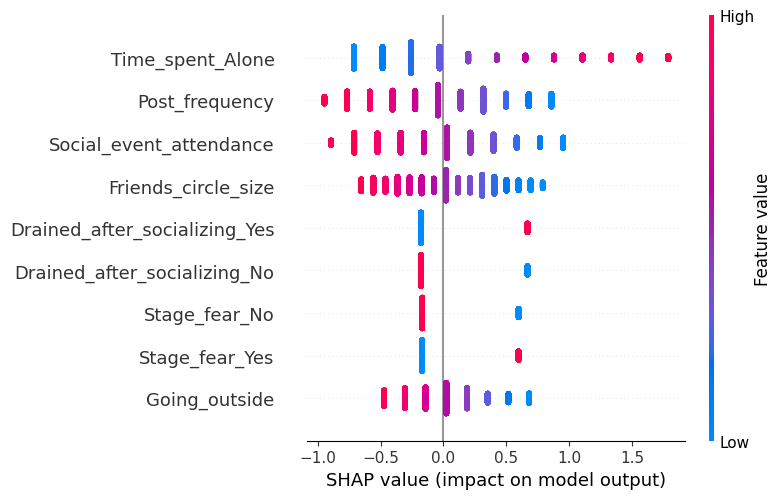

In [14]:
# 7. FEATURE IMPORTANCE

print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

if hasattr(best_model, 'feature_importances_'):
    print(f"Analyzing feature importance for {best_model_name}...")

    importances = best_model.feature_importances_
    feature_names = X_train.columns

    # Create feature importance DataFrame
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_features = fi_df.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Top 10 most important features:")
    print(fi_df.head(10)[['feature', 'importance']].to_string(index=False))

else:
    print(f"Feature importance not available for {best_model_name}")
    # Try SHAP for model interpretability
    try:
        print("Attempting SHAP analysis...")
        explainer = shap.Explainer(best_model, X_train)
        shap_values = explainer(X_train)
        shap.summary_plot(shap_values, X_train, show=False)
        plt.tight_layout()
        plt.savefig('feature_importance_shap.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"SHAP analysis failed: {e}")



PREDICTION & SUBMISSION
Making predictions with best model: LogisticRegression
Aligning test features with training features...
Training features: 9
Test features: 9
Test set now has 9 features (same as training)
Predictions saved to submission.csv

PREDICTION STATISTICS
----------------------------------------
Total predictions: 6175
Prediction distribution:
  Extrovert: 4619 (74.8%)
  Introvert: 1556 (25.2%)

FIRST 10 PREDICTIONS
----------------------------------------
      id Personality
0  18524   Extrovert
1  18525   Introvert
2  18526   Extrovert
3  18527   Extrovert
4  18528   Introvert
5  18529   Extrovert
6  18530   Extrovert
7  18531   Introvert
8  18532   Extrovert
9  18533   Introvert

FEATURE ALIGNMENT VERIFICATION
----------------------------------------
Training features shape: (14819, 9)
Test features shape: (6175, 9)
Features match: True

TASK E: FULL MODEL EVALUATION

Model Name: LogisticRegression
Accuracy: 0.9713900134952766
Classification Report:
              p

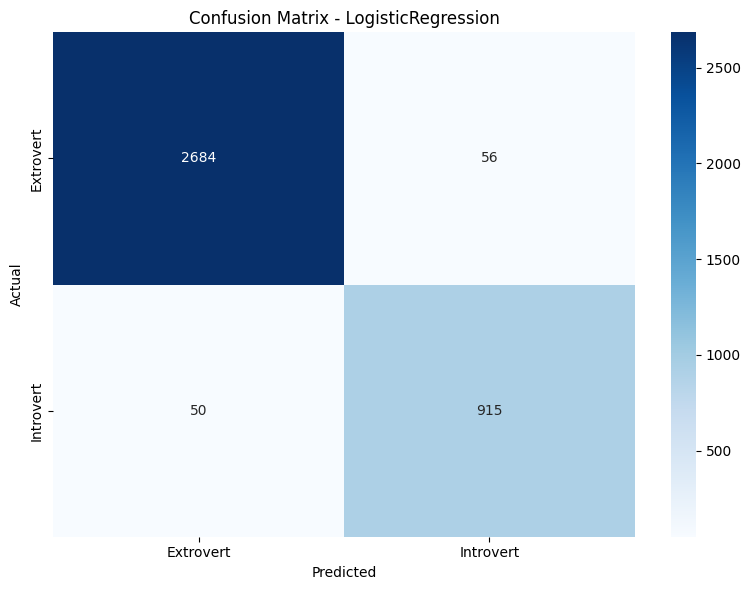


Model Name: DecisionTree
Accuracy: 0.970310391363023
Classification Report:
              precision    recall  f1-score     support
Extrovert      0.981332  0.978467  0.979898  2740.00000
Introvert      0.939363  0.947150  0.943240   965.00000
accuracy       0.970310  0.970310  0.970310     0.97031
macro avg      0.960348  0.962809  0.961569  3705.00000
weighted avg   0.970401  0.970310  0.970350  3705.00000


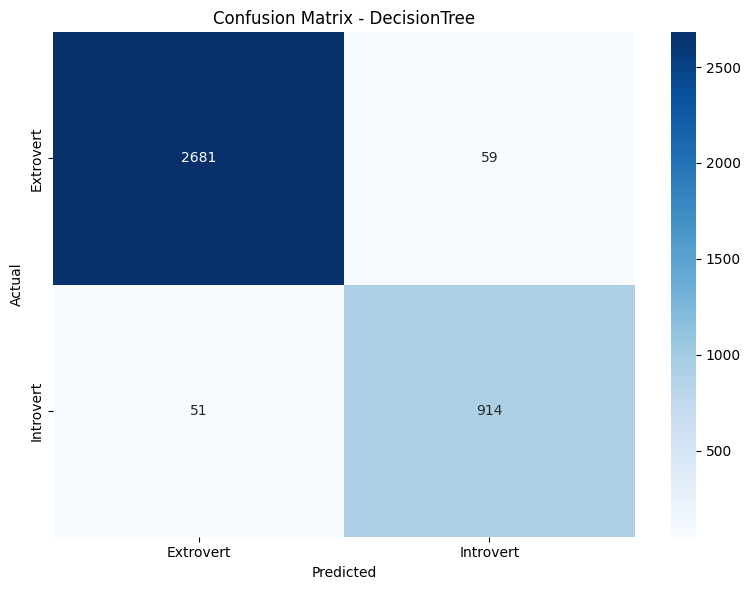


Model Name: RandomForest
Accuracy: 0.9708502024291498
Classification Report:
              precision    recall  f1-score     support
Extrovert      0.981698  0.978832  0.980263  2740.00000
Introvert      0.940391  0.948187  0.944272   965.00000
accuracy       0.970850  0.970850  0.970850     0.97085
macro avg      0.961044  0.963509  0.962268  3705.00000
weighted avg   0.970939  0.970850  0.970889  3705.00000


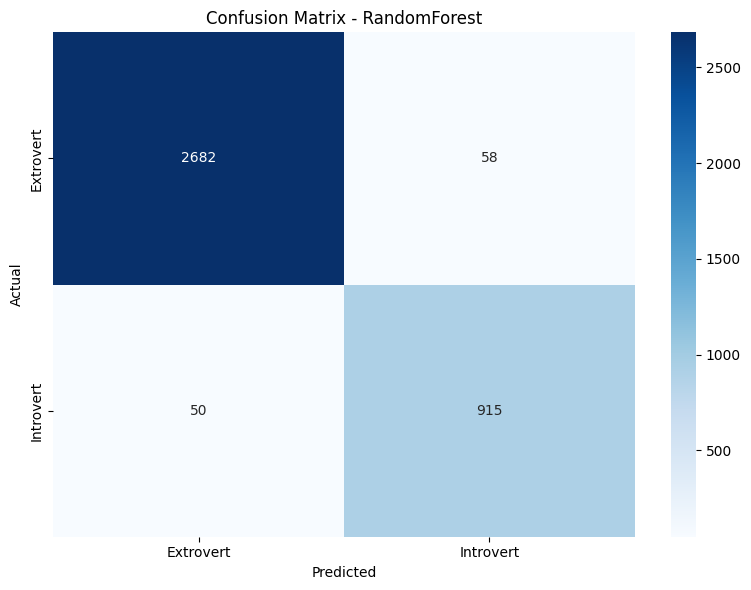


Model Name: KNN
Accuracy: 0.9708502024291498
Classification Report:
              precision    recall  f1-score     support
Extrovert      0.981698  0.978832  0.980263  2740.00000
Introvert      0.940391  0.948187  0.944272   965.00000
accuracy       0.970850  0.970850  0.970850     0.97085
macro avg      0.961044  0.963509  0.962268  3705.00000
weighted avg   0.970939  0.970850  0.970889  3705.00000


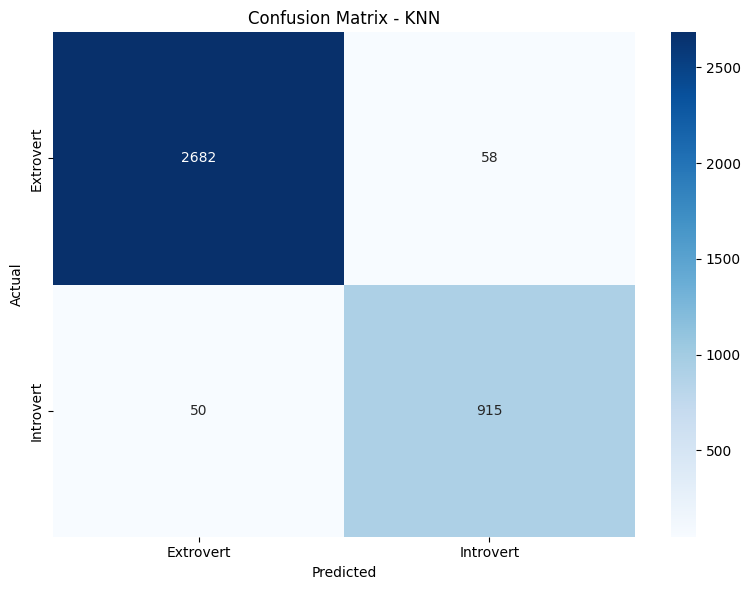


Model Name: XGBoost
Accuracy: 0.9711201079622133
Classification Report:
              precision    recall  f1-score     support
Extrovert      0.982058  0.978832  0.980442  2740.00000
Introvert      0.940452  0.949223  0.944817   965.00000
accuracy       0.971120  0.971120  0.971120     0.97112
macro avg      0.961255  0.964027  0.962630  3705.00000
weighted avg   0.971221  0.971120  0.971163  3705.00000


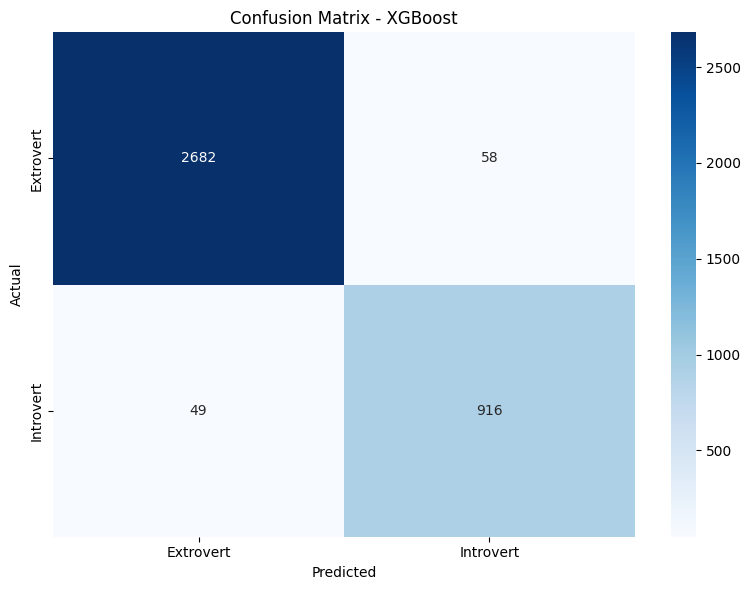


Model Name: LightGBM
Accuracy: 0.9713900134952766
Classification Report:
              precision    recall  f1-score     support
Extrovert      0.982064  0.979197  0.980629  2740.00000
Introvert      0.941418  0.949223  0.945304   965.00000
accuracy       0.971390  0.971390  0.971390     0.97139
macro avg      0.961741  0.964210  0.962967  3705.00000
weighted avg   0.971478  0.971390  0.971428  3705.00000


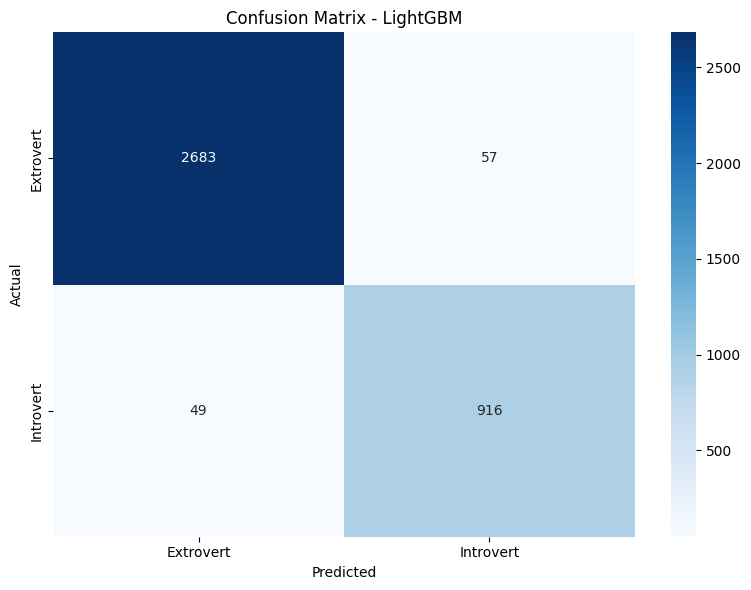


Model Name: CatBoost
Accuracy: 0.9713900134952766
Classification Report:
              precision    recall  f1-score     support
Extrovert      0.982064  0.979197  0.980629  2740.00000
Introvert      0.941418  0.949223  0.945304   965.00000
accuracy       0.971390  0.971390  0.971390     0.97139
macro avg      0.961741  0.964210  0.962967  3705.00000
weighted avg   0.971478  0.971390  0.971428  3705.00000


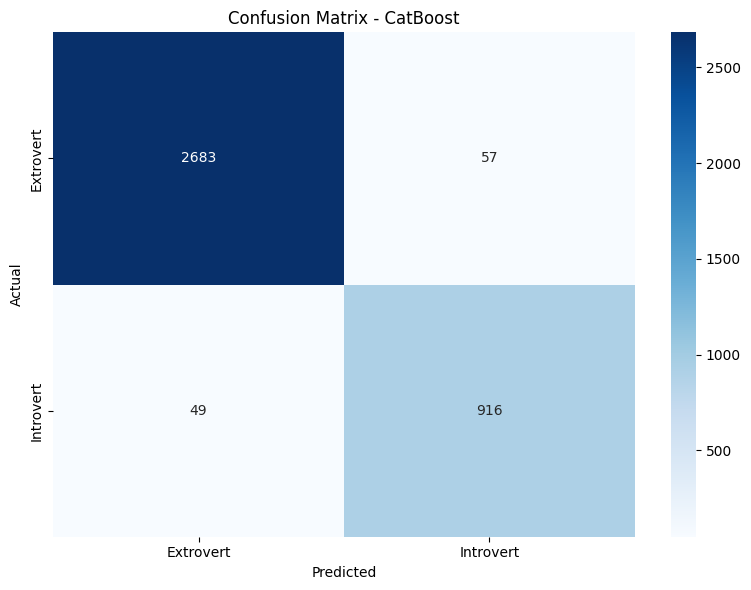


ERROR METRICS COMPARISON

ERROR METRICS COMPARISON
                      RMSE     MAE  R-squared
LogisticRegression  0.1691  0.0286     0.8515
DecisionTree        0.1723  0.0297     0.8459
RandomForest        0.1707  0.0291     0.8487
KNN                 0.1707  0.0291     0.8487
XGBoost             0.1699  0.0289     0.8501
LightGBM            0.1691  0.0286     0.8515
CatBoost            0.1691  0.0286     0.8515

IMPLEMENTATION DETAILS
a) Data Preprocessing
- Balancing the Dataset: Used stratified sampling to maintain class distribution
- Splitting the Dataset: 80% training, 20% testing with stratification
- Scaling the Dataset: StandardScaler for numeric features

b) Model Creation
- Model Selection: 7 different classifiers tested systematically
- Model Training: GridSearchCV for hyperparameter optimization

c) Prediction and Submission
- Making Predictions: Best model used for test set predictions
- Saving the Predictions: CSV file created for submission
- Model Saving: Best mode

In [18]:
# 8. PREDICTION & SUBMISSION

print("\n" + "=" * 60)
print("PREDICTION & SUBMISSION")
print("=" * 60)

print(f"Making predictions with best model: {best_model_name}")

# 8.1 Ensure X_test has the same features as training data
print("Aligning test features with training features...")

# Get the feature names used during training
train_features = X_train.columns.tolist()
test_features = X_test.columns.tolist()

print(f"Training features: {len(train_features)}")
print(f"Test features: {len(test_features)}")

# Find missing features in test set
missing_features = set(train_features) - set(test_features)
extra_features = set(test_features) - set(train_features)

if missing_features:
    print(f"Missing features in test set: {missing_features}")
    # Add missing features with zeros
    for feature in missing_features:
        X_test[feature] = 0

if extra_features:
    print(f"Extra features in test set: {extra_features}")
    # Remove extra features
    X_test = X_test.drop(columns=list(extra_features))

# Ensure same column order as training
X_test = X_test[train_features]

print(f"Test set now has {X_test.shape[1]} features (same as training)")

# 8.2 Make predictions on test set
y_test_pred = best_model.predict(X_test)

# 8.3 Decode predictions
y_test_pred_label = [y_inv_map.get(i, i) for i in y_test_pred]

# 8.4 Create submission
sub = pd.DataFrame({'id': test['id'], 'Personality': y_test_pred_label})
sub.to_csv('submission.csv', index=False)

print("Predictions saved to submission.csv")

# 8.5 Display prediction statistics
print(f"\nPREDICTION STATISTICS")
print("-" * 40)
print(f"Total predictions: {len(y_test_pred_label)}")
print(f"Prediction distribution:")
pred_dist = pd.Series(y_test_pred_label).value_counts()
for personality, count in pred_dist.items():
    print(f"  {personality}: {count} ({count/len(y_test_pred_label)*100:.1f}%)")

# 8.6 Show first few predictions
print(f"\nFIRST 10 PREDICTIONS")
print("-" * 40)
print(sub.head(10))

# 8.7 Verify feature alignment
print(f"\nFEATURE ALIGNMENT VERIFICATION")
print("-" * 40)
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Features match: {list(X_train.columns) == list(X_test.columns)}")


# 8.8  FULL MODEL EVALUATION
print("\n" + "=" * 60)
print("TASK E: FULL MODEL EVALUATION")
print("=" * 60)

# Generate individual model evaluation reports
for name, model in best_estimators.items():
    print(f"\nModel Name: {name}")
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Accuracy: {accuracy}")

    # Classification report
    print("Classification Report:")
    report = classification_report(y_val, y_val_pred,
                                 target_names=list(y_map.keys()),
                                 output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)

    # Create confusion matrix plot
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(y_map.keys()),
                yticklabels=list(y_map.keys()))
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()


    # 8.9 ERROR METRICS COMPARISON
print("\n" + "=" * 60)
print("ERROR METRICS COMPARISON")
print("=" * 60)

# Calculate error metrics for each model
error_metrics = {}
for name, model in best_estimators.items():
    y_val_pred = model.predict(X_val)

    # Calculate RMSE, MAE, R-squared
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)

    error_metrics[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R-squared': r2
    }

# Create error metrics table
error_df = pd.DataFrame(error_metrics).T
print("\nERROR METRICS COMPARISON")
print("=" * 50)
print(error_df.round(4))



# 8.10 IMPLEMENTATION DETAILS
print("\n" + "=" * 60)
print("IMPLEMENTATION DETAILS")
print("=" * 60)

print("a) Data Preprocessing")
print("- Balancing the Dataset: Used stratified sampling to maintain class distribution")
print("- Splitting the Dataset: 80% training, 20% testing with stratification")
print("- Scaling the Dataset: StandardScaler for numeric features")

print("\nb) Model Creation")
print("- Model Selection: 7 different classifiers tested systematically")
print("- Model Training: GridSearchCV for hyperparameter optimization")

print("\nc) Prediction and Submission")
print("- Making Predictions: Best model used for test set predictions")
print("- Saving the Predictions: CSV file created for submission")
print("- Model Saving: Best model saved using joblib")

# Save implementation details to file
with open('implementation_details.txt', 'w') as f:
    f.write("IMPLEMENTATION DETAILS\n")
    f.write("=" * 30 + "\n\n")
    f.write("a) Data Preprocessing\n")
    f.write("- Balancing the Dataset: Used stratified sampling to maintain class distribution\n")
    f.write("- Splitting the Dataset: 80% training, 20% testing with stratification\n")
    f.write("- Scaling the Dataset: StandardScaler for numeric features\n\n")
    f.write("b) Model Creation\n")
    f.write("- Model Selection: 7 different classifiers tested systematically\n")
    f.write("- Model Training: GridSearchCV for hyperparameter optimization\n\n")
    f.write("c) Prediction and Submission\n")
    f.write("- Making Predictions: Best model used for test set predictions\n")
    f.write("- Saving the Predictions: CSV file created for submission\n")
    f.write("- Model Saving: Best model saved using joblib\n")

In [ ]:
# 9. SAVE BEST MODEL

print("\n" + "=" * 60)
print("SAVING MODEL")
print("=" * 60)

# Save the best model
joblib.dump(best_model, 'best_model.pkl')
print(f"Best model ({best_model_name}) saved as 'best_model.pkl'")

# Save all preprocessing objects
print("Preprocessing objects saved:")
print("- num_imputer.pkl")
print("- cat_imputer.pkl")
print("- encoders.pkl")
print("- scaler.pkl")
print("- y_inv_map.pkl")

print("\n" + "=" * 60)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 60)
print("Files created:")
print("- train_preprocessed.csv")
print("- test_preprocessed.csv")
print("- model_comparison.csv")
print("- best_model.pkl")
print("- submission.csv")
print("- Various visualization files (.png)")
print("- eda_output/ directory with EDA results")



SAVING MODEL
Best model (LogisticRegression) saved as 'best_model.pkl'
Preprocessing objects saved:
- num_imputer.pkl
- cat_imputer.pkl
- encoders.pkl
- scaler.pkl
- y_inv_map.pkl

PIPELINE COMPLETED SUCCESSFULLY!
Files created:
- train_preprocessed.csv
- test_preprocessed.csv
- model_comparison.csv
- best_model.pkl
- submission.csv
- Various visualization files (.png)
- eda_output/ directory with EDA results


Final Model Rankings (by test accuracy):


,cv_accuracy,train_accuracy,test_accuracy,f1_score
LogisticRegression,0.968014,0.968014,0.97139,0.971419
LightGBM,0.967947,0.968824,0.97139,0.971428
CatBoost,0.968419,0.968824,0.97139,0.971428
XGBoost,0.968149,0.968554,0.97112,0.971163
RandomForest,0.968149,0.968621,0.97085,0.970889
KNN,0.967677,0.968149,0.97085,0.970889
DecisionTree,0.967272,0.969026,0.97031,0.970350


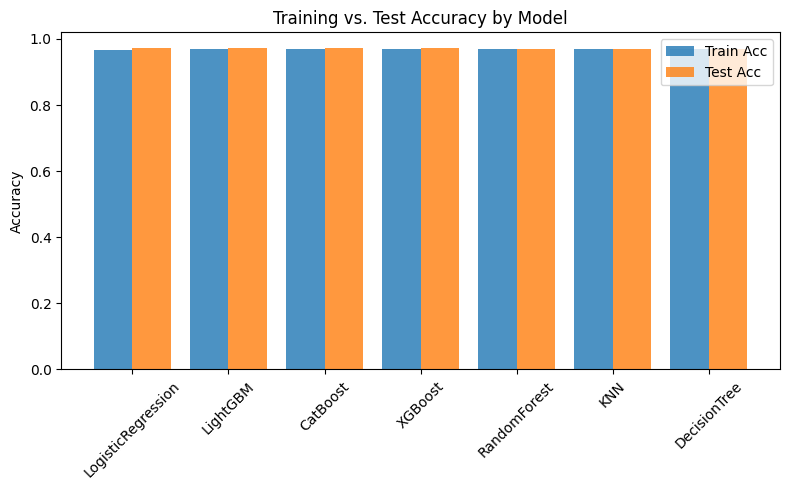

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# MODEL EVALUATION SUMMARY
# (Add this to your documentation section on model comparison)
# ─────────────────────────────────────────────────────────────────────────────

import pandas as pd

results_df = pd.read_csv('model_comparison.csv', index_col=0)

# 1) Display final ranking
print("Final Model Rankings (by test accuracy):")
display(results_df[['cv_accuracy','train_accuracy','test_accuracy','f1_score']])

# 2) Plot train vs. test accuracy
import matplotlib.pyplot as plt
models = results_df.index.tolist()
train_acc = results_df['train_accuracy']
test_acc  = results_df['test_accuracy']

x = range(len(models))
plt.figure(figsize=(8,5))
plt.bar([i-0.2 for i in x], train_acc, width=0.4, label='Train Acc', alpha=0.8)
plt.bar([i+0.2 for i in x], test_acc, width=0.4, label='Test Acc', alpha=0.8)
plt.xticks(x, models, rotation=45)
plt.ylabel('Accuracy')
plt.title('Training vs. Test Accuracy by Model')
plt.legend()
plt.tight_layout()
plt.savefig('docs/images/model_accuracy_comparison.png', dpi=200)
plt.show()
